I had posted my very naive baseline at https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019. In that kernel I only used the mode label for each Assessment and I thought it should be very easy to beat. This kernel shows how you can beat that baseline by actually applying a model. In this kernel via `get_data()` function, I go over each `installation_id` and try to extract some features based on his/her behavior prior to the assessment. I will then train a `Catboost` classifier on it and make predictions on the test set. Note that the features I made in this kernel are so very basic and you can easily add many more to it. Good luck and happy kaggling. Don't forget to upvote if you found it useful ;)

In [1]:
import numpy as np
import pandas as pd
import datetime
from catboost import CatBoostClassifier
from time import time
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.metrics import confusion_matrix
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
        
    return 1-np.divide(num,den)
    

In [3]:
train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')

In [4]:
# encode title
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

In [5]:
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [6]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [7]:
# no intersection between installation ids of train and test

In [8]:
# user_sample = train.query('installation_id=="0006a69f"')
# user_sample = test.query('installation_id=="01242218"') 

In [9]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    for i, session in user_sample.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        if test_set == True:
            second_condition = True
        else:
            if len(session)>1:
                second_condition = True
            else:
                second_condition= False
            
        if (session_type == 'Assessment') & (second_condition):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            features = user_activities_count.copy()
    #         features['installation_id'] = session['installation_id'].iloc[0]
#             features['game_session'] = i
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1

            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
            if test_set == True:
                all_assessments.append(features)
            else:
                if true_attempts+false_attempts > 0:
                    all_assessments.append(features)
                
            counter += 1

    #         break

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

    if test_set:
        return all_assessments[-1] 
    return all_assessments

In [10]:
compiled_data = []
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
    compiled_data += get_data(user_sample)

In [11]:
new_train = pd.DataFrame(compiled_data)
del compiled_data
new_train.shape

(17690, 16)

Below are the features I have generated. Note that all of them are **prior** to each event. For example, the first row shows **before** this assessment, the player have watched 3 clips, did 3 activities, played 4 games and solved 0 assessments, so on so forth.

In [12]:
new_train.head()

Clip  Activity  Assessment  Game  session_title  \
0    11         3           0     4             23   
1    14         4           1     6             22   
2    14         4           2     6             23   
3    24         9           4    10             23   
4    28        10           5    13             22   

   accumulated_correct_attempts  accumulated_uncorrect_attempts  \
0                             0                               0   
1                             1                               0   
2                             1                              11   
3                             2                              11   
4                             3                              12   

   duration_mean  accumulated_accuracy  accuracy_group  0  1  2  3  \
0           0.00                   0.0               3  0  0  0  0   
1          39.00                   1.0               0  0  0  0  1   
2          65.50                   0.5               3  1  0  0  1   
3          41.25                   0.5               2  2  0  0  2   
4          39.20                   0.5               3  2  0  1  2   

   accumulated_accuracy_group  accumulated_actions  
0                         0.0                  647  
1                         3.0                 1143  
2                         1.5                 1230  
3                         1.5                 2159  
4                         1.6                 2586

## Model

In [13]:
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
cat_features = ['session_title']
X, y = new_train[all_features], new_train['accuracy_group']
del train

In [14]:
def make_classifier():
    clf = CatBoostClassifier(
                               loss_function='MultiClass',
    #                            eval_metric="AUC",
                               task_type="CPU",
                               learning_rate=0.01,
                               iterations=2000,
                               od_type="Iter",
#                                depth=8,
                               early_stopping_rounds=500,
    #                            l2_leaf_reg=1,
    #                            border_count=96,
                               random_seed=2019
                              )
        
    return clf
oof = np.zeros(len(X))

In [15]:
# CV
from sklearn.model_selection import KFold
# preds = np.zeros(len(X_test))
oof = np.zeros(len(X))
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print(f'Training on fold {fold+1}')
    clf = make_classifier()
    clf.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                          use_best_model=True, verbose=500, cat_features=cat_features)
    
#     preds += clf.predict(X_test).reshape(len(X_test))/NFOLDS
    oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('OOF QWK:', qwk(y, oof))
print('-' * 30)

Training on fold 1
0:	learn: 1.3789744	test: 1.3791075	best: 1.3791075 (0)	total: 91ms	remaining: 3m 1s
500:	learn: 1.0056622	test: 1.0406488	best: 1.0406488 (500)	total: 14.4s	remaining: 43.1s
1000:	learn: 0.9793350	test: 1.0365426	best: 1.0365426 (1000)	total: 28.8s	remaining: 28.7s
1500:	learn: 0.9536437	test: 1.0353196	best: 1.0352998 (1498)	total: 43.7s	remaining: 14.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.035299848
bestIteration = 1498

Shrink model to first 1499 iterations.
Fold 1 finished in 0:00:59.186055
Training on fold 2
0:	learn: 1.3790256	test: 1.3793941	best: 1.3793941 (0)	total: 32.5ms	remaining: 1m 5s
500:	learn: 1.0056257	test: 1.0451022	best: 1.0451022 (500)	total: 14.1s	remaining: 42.3s
1000:	learn: 0.9806323	test: 1.0372131	best: 1.0372131 (1000)	total: 28.4s	remaining: 28.3s
1500:	learn: 0.9569187	test: 1.0334982	best: 1.0334933 (1499)	total: 43.1s	remaining: 14.3s
1999:	learn: 0.9375831	test: 1.0320896	best: 1.0320784 (1998)	total:

Note that Cross validation is only for the feature engineering part and you don't actually need it if you want to submit the results. You can safely comment it out. 

In [16]:
# train model on all data once
clf = make_classifier()
clf.fit(X, y, verbose=500, cat_features=cat_features)

del X, y

0:	learn: 1.3788747	total: 35.8ms	remaining: 1m 11s
500:	learn: 1.0112254	total: 15.9s	remaining: 47.7s
1000:	learn: 0.9886015	total: 32.4s	remaining: 32.3s
1500:	learn: 0.9674059	total: 49.1s	remaining: 16.3s
1999:	learn: 0.9500427	total: 1m 5s	remaining: 0us


In [17]:
# process test set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
X_test = pd.DataFrame(new_test)
del test

In [18]:
# make predictions on test set once
preds = clf.predict(X_test)
del X_test

## Make submission

In [19]:
submission['accuracy_group'] = np.round(preds).astype('int')
submission.to_csv('submission.csv', index=None)
submission.head()

installation_id  accuracy_group
0        00abaee7               3
1        01242218               3
2        017c5718               3
3        01a44906               3
4        01bc6cb6               3

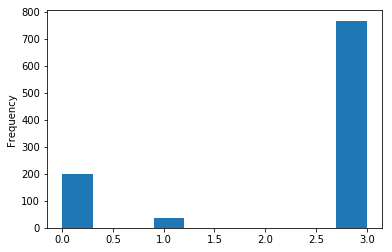

In [20]:
submission['accuracy_group'].plot(kind='hist')

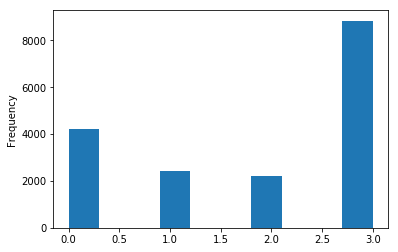

In [21]:
train_labels['accuracy_group'].plot(kind='hist')

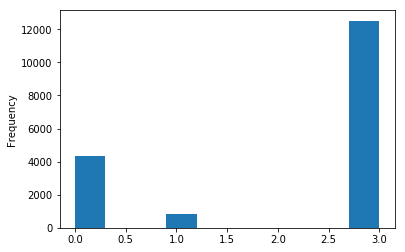

In [22]:
pd.Series(oof).plot(kind='hist')